In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re          # Remove punctuation/special chars ,Remove extra whitespace
# import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

# import torch                #for ANN (not done yet)
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader

In [6]:
# import os
# os.chdir(os.path.dirname(os.path.abspath("/home/sama/PycharmProjects/ML Project/Machine_Learning_Project.ipynb")))
# os.getcwd()

In [7]:
# base_dir=('/content/drive/MyDrive/ML project')
# glove_path = "/content/drive/MyDrive/ML project/glove.6B.100d.txt"
glove_path = "glove.6B.100d.txt"

# Functions


In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

#   # Compute average word vector for each paragraph
# def paragraph_to_vector(tokens, embeddings, dim=100):
#     vectors = [embeddings[word] for word in tokens if word in embeddings]
#     if len(vectors) == 0:
#         return np.zeros(dim)  # fallback if all words are OOV
#     return np.mean(vectors, axis=0)

def paragraph_to_vector(tokens, embeddings, tfidf_vectorizer, dim=100):
    filtered_tokens = [word for word in tokens if word in embeddings]

    if len(filtered_tokens) == 0:
        return np.zeros(dim)  # Fallback for all-OOV paragraphs

    # Compute TF-IDF vector for the paragraph (joined string of tokens)
    tfidf_weights_full = tfidf_vectorizer.transform([' '.join(filtered_tokens)]).toarray()[0]

    # Match TF-IDF weights to the filtered tokens using the vectorizer's vocabulary
    vocab = tfidf_vectorizer.get_feature_names_out()        ## ['bone', 'clear', 'detected', ..., 'xray']
    word2index = {word: i for i, word in enumerate(vocab)}

    tfidf_weights = [
        tfidf_weights_full[word2index[word]] if word in word2index else 0.0
        for word in filtered_tokens
    ]

    # Compute weighted embeddings
    weighted_vectors = np.array([
        embeddings[word] * tfidf_weights[i]
        for i, word in enumerate(filtered_tokens)
    ])

    # Return the average of the weighted vectors
    return np.mean(weighted_vectors, axis=0)


def count_oov_words(tokens, embeddings):
    oov_count = 0
    for word in tokens:
        if word not in embeddings:
            oov_count += 1
    return oov_count




# Reading data

In [9]:
# df=pd.read_csv(base_dir+'/filtered3_paragraphs.csv')
df = pd.read_csv('filtered3_paragraphs.csv')
data=pd.DataFrame(df)
data.head()

,text,generated,topic
0,there is no single answer to the question of w...,1,education
1,education is a crucial part of every individua...,1,education
2,online schools zs traditional schools which bs...,1,education
3,education is an essential component of human l...,1,education
4,hey its me your average 8th grade student for...,1,education


In [10]:
data.rename(columns={'generated': 'label'}, inplace=True)
print(data['label'].value_counts())


label
1    150
0    150
Name: count, dtype: int64


In [25]:
data["topic"].value_counts()

topic
education     100
healthcare    100
science       100
Name: count, dtype: int64

### clean & Tokenize Text

In [11]:
data['clean_text'] = data['text'].apply(clean_text)
data['tokens'] = data['clean_text'].apply(lambda x: x.split())



In [12]:
display(data[['label', 'clean_text', 'tokens']].head())

,label,clean_text,tokens
0,1,there is no single answer to the question of w...,"[there, is, no, single, answer, to, the, quest..."
1,1,education is a crucial part of every individua...,"[education, is, a, crucial, part, of, every, i..."
2,1,online schools zs traditional schools which bs...,"[online, schools, zs, traditional, schools, wh..."
3,1,education is an essential component of human l...,"[education, is, an, essential, component, of, ..."
4,1,hey its me your average 8th grade student for ...,"[hey, its, me, your, average, 8th, grade, stud..."


### Vectorize Using Word Embeddings

What is GloVe?
*   Converts words (like "cat", "intelligence") into 100-dimensional vectors.
*   Words with similar meanings have similar vectors.
*   These vectors allow machine learning models to understand text numerically.






In [13]:
embeddings = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector


corpus = data['tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(corpus)
print("Loaded GloVe embeddings. Total words:", len(embeddings))
data['vector'] = data['tokens'].apply(lambda tokens: paragraph_to_vector(tokens, embeddings,tfidf_vectorizer))

Loaded GloVe embeddings. Total words: 400001


In [14]:
data.head()

,text,label,topic,clean_text,tokens,vector
0,there is no single answer to the question of w...,1,education,there is no single answer to the question of w...,"[there, is, no, single, answer, to, the, quest...","[-0.01593094, 0.05231088, 0.036427163, -0.0027..."
1,education is a crucial part of every individua...,1,education,education is a crucial part of every individua...,"[education, is, a, crucial, part, of, every, i...","[-0.0047521135, 0.029845364, 0.017792812, -0.0..."
2,online schools zs traditional schools which bs...,1,education,online schools zs traditional schools which bs...,"[online, schools, zs, traditional, schools, wh...","[0.008893882, 0.04885239, -0.017433826, -0.014..."
3,education is an essential component of human l...,1,education,education is an essential component of human l...,"[education, is, an, essential, component, of, ...","[0.0034296457, 0.040322654, -0.007878398, 0.01..."
4,hey its me your average 8th grade student for...,1,education,hey its me your average 8th grade student for ...,"[hey, its, me, your, average, 8th, grade, stud...","[-0.014221176, 0.043774586, 0.06623217, -0.033..."


In [15]:
data.loc[0,"vector"].shape

(100,)

In [16]:
# To check
print('hello' in embeddings)
print('asdfghjkl' in embeddings)

True
False


### Splitting

In [17]:
x_train, x_test, y_train, y_test = train_test_split(data['vector'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42)

### Save the dataset

In [18]:
X_all=data.drop(['label'],axis=1)
y_all=data['label']

x_all_train , x_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)



In [19]:
data.to_csv('vector_dataset.csv', index=False)


In [20]:
# train_data = pd.DataFrame({
#     'vector': x_train,
#     'label': y_train
# })

# test_data = pd.DataFrame({
#     'vector': x_test,
#     'label': y_test
# })

train_data = pd.concat([x_all_train, y_all_train], axis=1)
test_data = pd.concat([x_all_test, y_all_test], axis=1)

train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

In [21]:
# total_oov_count = 0
total_oov_count = (data['tokens'].apply(lambda tokens: count_oov_words(tokens, embeddings))).sum()


embedding_dim = len(data['vector'][0])
total_paragraphs = len(data)
num_ai = len(data[data['label'] == 0])
num_human = len(data[data['label'] == 1])


# vocab_size = embedding_dim
used_vocab = set(word for tokens in data['tokens'] for word in tokens if word in embeddings)
vocab_size = len(used_vocab)


# OOV (out-of-vocabulary) handling it by using zero vectors for unknown words
oov_handling = 'filters out OOV words'

with open('embedding_report.txt', 'w') as f:
    f.write(f"Dataset Statistics:\n")
    f.write(f"Total number of paragraphs: {total_paragraphs}\n")
    f.write(f"Number of AI samples: {num_ai}\n")
    f.write(f"Number of Human samples: {num_human}\n")
    f.write("\n\n")

    f.write(f"Embedding Model: GloVe\n")
    f.write(f"Embedding Dimensions: {embedding_dim}\n")
    f.write("\n\n")

    f.write(f"Vocabulary Size: {vocab_size}\n")
    f.write("\n\n")


    f.write(f"OOV Handling: {oov_handling}\n")
    f.write(f"Total OOV words encountered across all paragraphs: {total_oov_count}\n")



In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

# Supervised Learning Task

#### logistic regression


In [23]:
LRmodel = LogisticRegression(max_iter=1000)
LRmodel.fit(x_train, y_train)

# Predict
y_train_pred = LRmodel.predict(x_train)
y_test_pred = LRmodel.predict(x_test)

# Report
print("Logistic Regression Performance:")
print("Accuracy for train:", accuracy_score(y_train, y_train_pred))
print("Accuracy for test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Logistic Regression Performance:
Accuracy for train: 0.7833333333333333
Accuracy for test: 0.7
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        31
           1       0.72      0.62      0.67        29

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60



D:\anaconda2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Adjusted Rand Index on training set: 0.016009687759723303
Adjusted Rand Index on test set: 0.018013576657233243


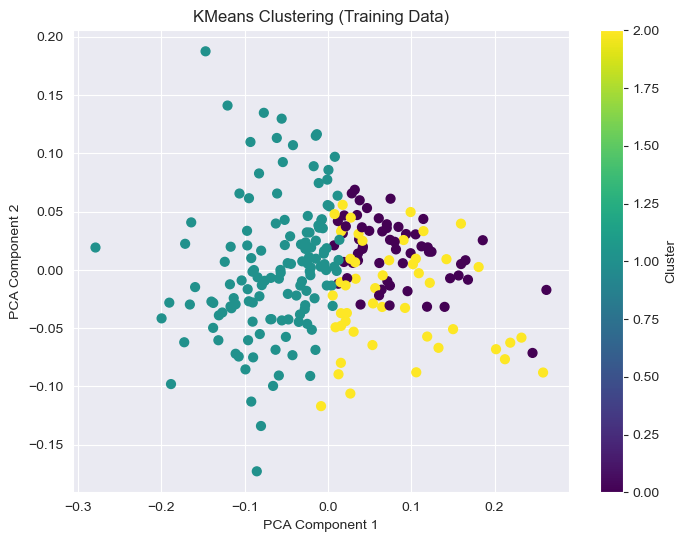

In [37]:
X_Train_KMeans, X_Test_KMeans, Y_Train_KMeans, Y_Test_Kmeans = train_test_split(
    data["vector"], data["topic"], test_size=0.2, random_state=42
)

# 2. Convert to NumPy arrays (from lists of vectors)
X_Train_KMeans = np.array(X_Train_KMeans.tolist())
X_Test_KMeans = np.array(X_Test_KMeans.tolist())

# 3. Apply KMeans clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_Train_KMeans)

# 4. Predict cluster labels
train_clusters = kmeans.predict(X_Train_KMeans)
test_clusters = kmeans.predict(X_Test_KMeans)

# 5. Evaluate clustering vs actual topic labels
train_ari = adjusted_rand_score(Y_Train_KMeans, train_clusters)
test_ari = adjusted_rand_score(Y_Test_Kmeans, test_clusters)

print("Adjusted Rand Index on training set:", train_ari)
print("Adjusted Rand Index on test set:", test_ari)

# 6. Visualize training clusters using PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_Train_KMeans)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=train_clusters, cmap='viridis', s=40)
plt.title('KMeans Clustering (Training Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [35]:
data['cluster'] = kmeans.labels_
data['topic'] = data['topic'].astype(str)  # for groupby

for c in range(num_clusters):
    print(f"\nCluster {c} topic breakdown:")
    print(data[data['cluster'] == c]['topic'].value_counts())


ValueError: Length of values (240) does not match length of index (300)